In [1]:
import pandas as pd
df = pd.read_csv('y_train.csv', header=None)

In [17]:
import numpy as np
import csv
import pandas as pd

# Activation functions and their derivatives
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return np.where(x <= 0, 0, 1)

def sigmoid_derivative(x):
    return x * (1 - x)

def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

def accuracy_score(y_true, y_pred):
    correct_predictions = np.sum(np.argmax(y_true, axis=1) == np.argmax(y_pred, axis=1))
    total_predictions = y_true.shape[0]
    return correct_predictions / total_predictions


# Loss functions and their derivatives
def categorical_crossentropy(y_true, y_pred):
    return -np.sum(y_true * np.log(y_pred + 1e-9)) / y_true.shape[0]

def categorical_crossentropy_derivative(y_true, y_pred):
    return y_pred - y_true


class BaseNeuralNetwork:
    def __init__(self, initial_weights=None, initial_biases=None, layer_sizes=None):
        self.layer_sizes = layer_sizes
        if layer_sizes:
            self.num_layers = len(layer_sizes)
        self.layer_initializer_from_initial(layer_sizes, initial_weights, initial_biases)
        self.gead_w = []
        self.grad_b = []
    
    def layer_initializer_from_initial(self, layer_sizes, weights_file, biases_file):
        # Initialize weights
        if weights_file is None:
            self.weights = [np.random.randn(layer_sizes[i], layer_sizes[i+1]) for i in range(self.num_layers - 1)]
            self.biases = [np.random.randn(i) for i in self.layer_sizes[1:]]
        else:
            with open(weights_file, 'r') as wf:
                reader = csv.reader(wf)
                weights = []
                layer_sizes = []
                current_layer = None
                current_weights = []

                for row in reader:
                    layer_info = row[0]
                    parts = layer_info.split(' ')
                    layer_from = int(parts[2][5:])
                    layer_to = int(parts[4][5:])

                    if current_layer is None:
                        current_layer = layer_from
                        # layer_sizes.append(len(row) - 1)  # Input layer size

                    if current_layer != layer_from:
                        layer_sizes.append(len(current_weights))  # Previous layer size
                        weights.append(np.array(current_weights))
                        current_weights = []
                        current_layer = layer_from

                    current_weights.append(np.array(row[1:], dtype=np.float32))

                # Append the metadata about the last layer
                layer_sizes.append(len(current_weights))
                layer_sizes.append(len(current_weights[0]))
                #adding the num layers
                self.num_layers = len(layer_sizes)
                weights.append(np.array(current_weights))

                self.weights = weights
                self.layer_sizes = layer_sizes
#                print(self.layer_sizes)
            
            with open(biases_file, 'r') as bf:
                reader = csv.reader(bf)
                biases = []
                for row in reader:
                    layer_biases = np.array(row[1:], dtype=np.float32)
                    biases.append(layer_biases)
                    self.biases = biases

    def save_gradients(self, w,b):
        with open(w, 'w', newline='') as wf:
            writer = csv.writer(wf)
            for i in range(len(self.grad_w)):
                for x in self.grad_w[i]:
                    temp_row = x
                    writer.writerow(temp_row)
        with open(b, 'w', newline='') as bf:
            writer = csv.writer(bf)
            for i in range(len(self.grad_b)):
                temp_row = self.grad_b[i]
                writer.writerow(temp_row)
        
        
        
    def get_weights(self):
        print([s.shape for s in self.weights])
        return self.weights

    def get_biases(self):
        print([s.shape for s in self.biases])
        return self.biases


class NeuralNetwork(BaseNeuralNetwork):
    def __init__(self, layer_sizes, initial_weights=None, initial_biases=None):
        super().__init__( initial_weights, initial_biases, layer_sizes)
        self.history = {}

        

    
    def forward_propagation(self, X):
        activations = [X]
        for i in range(self.num_layers - 1):
            net_input = np.dot(activations[-1], self.weights[i]) + self.biases[i]
            if i == self.num_layers - 2:
                activation = softmax(net_input)  # Use softmax in the output layer
            else:
                activation = relu(net_input)
            activations.append(activation)
        return activations
    
    def backward_propagation(self, X, y, activations, learning_rate):
        deltas = [categorical_crossentropy_derivative(y, activations[-1])]
        
        for i in range(self.num_layers - 2, 0, -1):
            delta = deltas[-1].dot(self.weights[i].T) * relu_derivative(activations[i])
            deltas.append(delta)
        
        deltas.reverse()

        self.grad_w = []
        self.grad_b = []
        
        for i in range(self.num_layers - 1):
            self.grad_w.append(activations[i].T.dot(deltas[i]))
            self.grad_b.append(np.sum(deltas[i], axis=0))
            self.weights[i] -= activations[i].T.dot(deltas[i]) * learning_rate
            self.biases[i] -= np.sum(deltas[i], axis=0) * learning_rate
    
    def train(self, X, y, epochs, learning_rate, testX=None, testY=None):
        training_loss = []
        testing_loss = []
        train_accuracy = []
        test_accuracy = []
        for epoch in range(epochs):
            activations = self.forward_propagation(X)
            self.backward_propagation(X, y, activations, learning_rate)
            loss = categorical_crossentropy(y, activations[-1])
            training_loss.append(loss)
           
            train_accuracy.append(accuracy_score(y, activations[-1]))
            if testX is not None:
                act = self.forward_propagation(testX)[-1]
                testing_loss.append(categorical_crossentropy(testY,act ))
                test_accuracy.append(accuracy_score(testY,act))
            # self.history["training_loss"].append(loss)
            print(f'Epoch {epoch}, Loss: {loss}')

        self.history["training_loss"] = training_loss
        self.history["testing_loss"] = testing_loss
        self.history["train_accuracy"] = train_accuracy
        self.history["test_accuracy"] = test_accuracy

In [5]:
df_one_hot = pd.get_dummies(df, columns=[0]).astype('int')
df_one_hot.values

array([[0, 0, 0, 1],
       [0, 1, 0, 0],
       [0, 0, 1, 0],
       ...,
       [1, 0, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0]])

In [50]:
layer_sizes = [14, 100, 40,4]
epochs = 10
learning_rate = 0.001
nn = NeuralNetwork(layer_sizes)
trainX = pd.read_csv("x_train.csv", header=None)
trainY = pd.read_csv("y_train.csv", header=None)
testX = pd.read_csv("x_test.csv", header=None)
testY = pd.read_csv("y_test.csv", header=None)
trainY_one_hot = pd.get_dummies(trainY, columns=[0]).astype('int').values
testY_one_hot = pd.get_dummies(testY, columns=[0]).astype('int').values
trainX, testX = trainX.values, testX.values
nn.train(trainX, trainY_one_hot, epochs, learning_rate, testX, testY_one_hot)

Epoch 0, Loss: 14.777354369536807
Epoch 1, Loss: 15.006066686109895
Epoch 2, Loss: 7.102872043135154
Epoch 3, Loss: 3.9969851918374903
Epoch 4, Loss: 3.0469026222041875
Epoch 5, Loss: 3.314494442699345
Epoch 6, Loss: 2.8719027273396356
Epoch 7, Loss: 2.2486093129087816
Epoch 8, Loss: 2.3726566811186847
Epoch 9, Loss: 3.089896112922602


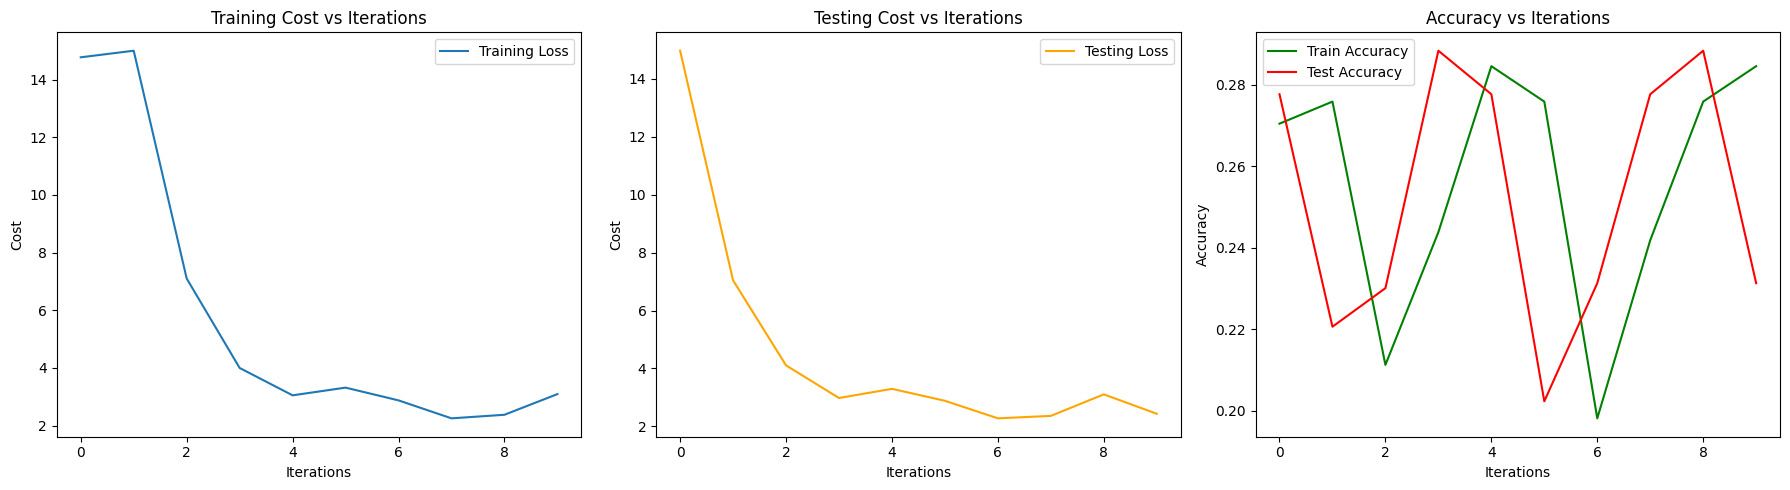

In [51]:
import matplotlib.pyplot as plt

# Extract data from the history dictionary
training_loss = nn.history["training_loss"]
testing_loss = nn.history["testing_loss"]
train_accuracy = nn.history["train_accuracy"]
test_accuracy = nn.history["test_accuracy"]

# Create a 1x3 grid for the plots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot the training cost w.r.t. iterations
axes[0].plot(training_loss, label='Training Loss')
axes[0].set_title('Training Cost vs Iterations')
axes[0].set_xlabel('Iterations')
axes[0].set_ylabel('Cost')
axes[0].legend()

# Plot the testing cost w.r.t. iterations
axes[1].plot(testing_loss, label='Testing Loss', color='orange')
axes[1].set_title('Testing Cost vs Iterations')
axes[1].set_xlabel('Iterations')
axes[1].set_ylabel('Cost')
axes[1].legend()

# Plot the train & test accuracy scores w.r.t. iterations
axes[2].plot(train_accuracy, label='Train Accuracy', color='green')
axes[2].plot(test_accuracy, label='Test Accuracy', color='red')
axes[2].set_title('Accuracy vs Iterations')
axes[2].set_xlabel('Iterations')
axes[2].set_ylabel('Accuracy')
axes[2].legend()

# Show the plots
plt.tight_layout()
plt.show()